In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt

In [43]:
class Planewave_t:
    """
    A class to hold planewave parameters, equivalent to the C struct planewave_t.
    """
    """
    def __init__(self, theta=0, phi=0, ei=None, hi=None, ri=None, r0=None, ai=0, pol=0):
        self.theta = theta
        self.phi = phi
        self.ei = np.zeros(3, dtype=np.float64) if ei is None else np.array(ei, dtype=np.float64)
        self.hi = np.zeros(3, dtype=np.float64) if hi is None else np.array(hi, dtype=np.float64)
        self.ri = np.zeros(3, dtype=np.float64) if ri is None else np.array(ri, dtype=np.float64)
        self.r0 = np.zeros(3, dtype=np.float64) if r0 is None else np.array(r0, dtype=np.float64)
        self.ai = ai
        self.pol = pol
    """
    def __init__(self, pw):
        self.theta = pw[0]
        self.phi = pw[1]
        self.ei = np.array([pw[2], pw[3], pw[4]])
        self.hi = np.array([pw[5], pw[6], pw[7]])
        self.ri = np.array([pw[8], pw[9], pw[10]])
        self.r0 = np.array([pw[11], pw[12], pw[13]])
        self.ai = pw[14]
        self.pol = pw[15]
        


In [3]:
od.data["Xn"]

NameError: name 'od' is not defined

In [12]:
od.data["Planewave"]

(90.0,
 0.0,
 -6.123233995736766e-17,
 -0.0,
 1.0,
 -0.0,
 1.0,
 0.0,
 -1.0,
 -0.0,
 -6.123233995736766e-17,
 0.3097730308019983,
 0.0,
 1.8968127531692084e-17,
 9448818897.637794,
 1)

In [15]:
x0, y0, z0 = od.data["Planewave"][11:14]

In [16]:
x0

0.3097730308019983

In [46]:
# def cal_planewave(freq, x, y, z, planewave_data):
def cal_planewave(od, i, j, k):
    """
    od.data["Planewave"]
    typedef struct {
    	double theta, phi;        // direction
    	double ei[3], hi[3];      // E and H unit vector
    	double ri[3], r0[3], ai;  // incidence vector and factor
    	int    pol;               // polarization : 1=V, 2=H
    } planewave_t;                // plane wave incidence
    
    Calculates the electric and magnetic fields of a plane wave at a given point.

    Args:
        freq (float): Frequency of the plane wave in Hz.
        x (float): x-coordinate of the point.
        y (float): y-coordinate of the point.
        z (float): z-coordinate of the point.
        planewave_data (Planewave_t): An object containing the planewave parameters.

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing the electric field vector (e)
                                       and magnetic field vector (h) as NumPy arrays.
                                       Returns (None, None) if planewave is not active.
    """
    freq = 0.0
    for idx in range(od.NFreq2):
        freq = freq + od.data["Freq2"][idx]
    freq = freq / od.NFreq2
    Xn = od.data["Xn"]
    Yn = od.data["Yn"]
    Zn = od.data["Zn"]
    
    C0 = 3e8
    k0 = 2 * np.pi * freq / C0
    
    pw = Planewave_t(od.data["Planewave"])
#    x0, y0, z0 = od.data["Planewave"][11:14]
    x0 = pw.r0[0]
    y0 = pw.r0[1]
    z0 = pw.r0[2]
    
    x = Xn[i]    
    y = Yn[j]    
    z = Zn[k]    

    rri = ((x - x0) * pw.ri[0] +    # planewave_data.ri[0] +
           (y - y0) * pw.ri[1] +    # planewave_data.ri[1] +
           (z - z0) * pw.ri[2])     # planewave_data.ri[2])

    phs = np.exp(1j * k0 * rri)

    # Note: The ei and hi vectors are unit vectors for the field components.
    # They should be treated as complex values if they represent phase at the origin.
    # The C code implicitly handles them as doubles, which we replicate here.
    # e = planewave_data.ei.astype(np.complex128) * phs
    # h = planewave_data.hi.astype(np.complex128) * phs
    e = pw.ei * phs
    h = pw.hi * phs

    return e, h


In [22]:
a = np.array([1,2,3])

In [35]:
od.data["Planewave"][3]

-0.0

In [56]:
eint = np.zeros((30, 30)) 
for x in range(30):
    y = 15;
    for z in range(30):
        e, h = cal_planewave(od, x, y, z)
        eint[x, z] =  np.real(e[2])

In [57]:
e

array([ 1.97503706e-17+5.79596611e-17j,  0.00000000e+00+0.00000000e+00j,
       -3.22548030e-01-9.46553099e-01j])

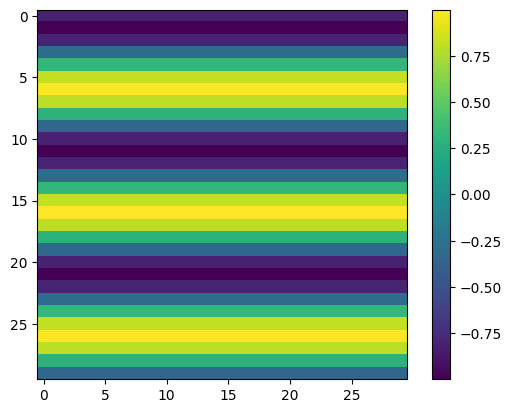

In [58]:
plt.imshow(eint)
plt.colorbar()

In [6]:
filename = 'ofd.out'

data = {}
    
with open(filename, "rb") as f:
    # Title (256 characters)
    data["Title"] = f.read(256).decode("ascii", errors="ignore").rstrip("\x00")

    # Read multiple ints (15 in total). NN is 8-byte, so use 'q' instead of 'i'.
    fmt = "<iiiiiiiqiiiiiiiidii"
    sz = struct.calcsize(fmt)
    ints = struct.unpack(fmt, f.read(sz))
    (Nx, Ny, Nz, Ni, Nj, Nk, N0, NN,
     NFreq1, NFreq2, NFeed, NPoint, Niter, Ntime,
     Solver_maxiter, Solver_nout, Dt, NGline, IPlanewave) = ints[:19]

    # --- Read planewave_t ---
    # typedef struct {
    #    double theta, phi;
    #    double ei[3], hi[3];
    #    double ri[3], r0[3], ai;
    #    int pol;
    # } planewave_t;
    fmt = "2d 3d 3d 3d 3d d i"
    planewave = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
    data["Planewave"] = planewave

    fmt = "i"
    temp = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
    
    # --- Read arrays with numpy ---
    def read_array(dtype, count):
        byte_size = np.dtype(dtype).itemsize * count
        return np.frombuffer(f.read(byte_size), dtype=dtype, count=count)

    data["Xn"] = read_array(np.float64, Nx + 1)
    data["Yn"] = read_array(np.float64, Ny + 1)
    data["Zn"] = read_array(np.float64, Nz + 1)

    data["Xc"] = read_array(np.float64, Nx)
    data["Yc"] = read_array(np.float64, Ny)
    data["Zc"] = read_array(np.float64, Nz)

    data["Eiter"] = read_array(np.float64, Niter)
    data["Hiter"] = read_array(np.float64, Niter)

    data["VFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
    data["IFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
    data["VPoint"] = read_array(np.float64, NPoint * (Solver_maxiter + 1))

    data["Freq1"] = read_array(np.float64, NFreq1)
    data["Freq2"] = read_array(np.float64, NFreq2)

    # --- Read feed_t ---
    # feed_t {
    #    char dir; int i,j,k; double dx,dy,dz; double volt; double delay; double z0;
    # }
    feed_fmt = "c 3i 3d 3d"
    feed_size = struct.calcsize(feed_fmt)
    Feed = []
    for _ in range(NFeed):
        Feed.append(struct.unpack(feed_fmt, f.read(feed_size)))
    data["Feed"] = Feed

    # complex (double,double)
    data["Zin"] = read_array(np.complex128, NFeed * NFreq1)
    data["Ref"] = read_array(np.float64, NFeed * NFreq1)

    data["Pin0"] = read_array(np.float64, NFeed * NFreq2)
    data["Pin1"] = read_array(np.float64, NFeed * NFreq2)

    data["Spara"] = read_array(np.complex128, NPoint * NFreq1)
    data["Gline"] = read_array(np.float64, NGline * 2 * 3)

    # --- Surface ---
    NSurface = struct.unpack("i", f.read(4))[0]

    # typedef struct { double nx,ny,nz,x,y,z,ds; } surface_t;
    surf_fmt = "7d"
    surf_size = struct.calcsize(surf_fmt)
    Surface = []
    for _ in range(NSurface):
        Surface.append(struct.unpack(surf_fmt, f.read(surf_size)))
    data["Surface"] = Surface

    # SurfaceEx/Ey/Ez/Hx/Hy/Hz (complex)
    SurfaceData = {}
    for ifreq in range(NFreq2):
        SurfaceData[ifreq] = {
            "Ex": read_array(np.complex128, NSurface),
            "Ey": read_array(np.complex128, NSurface),
            "Ez": read_array(np.complex128, NSurface),
            "Hx": read_array(np.complex128, NSurface),
            "Hy": read_array(np.complex128, NSurface),
            "Hz": read_array(np.complex128, NSurface),
        }
    data["SurfaceFields"] = SurfaceData

    # --- cEx_r etc (float) ---
    c_fields = {}
    for ifreq in range(NFreq2):
        c_fields[ifreq] = {
            "Ex_r": read_array(np.float32, NN),
            "Ex_i": read_array(np.float32, NN),
            "Ey_r": read_array(np.float32, NN),
            "Ey_i": read_array(np.float32, NN),
            "Ez_r": read_array(np.float32, NN),
            "Ez_i": read_array(np.float32, NN),
            "Hx_r": read_array(np.float32, NN),
            "Hx_i": read_array(np.float32, NN),
            "Hy_r": read_array(np.float32, NN),
            "Hy_i": read_array(np.float32, NN),
            "Hz_r": read_array(np.float32, NN),
            "Hz_i": read_array(np.float32, NN),
        }
    data["cfield"] = c_fields

    # Last number (num)
    data["num_written"] = struct.unpack("Q", f.read(8))[0]

In [7]:
# class for reading file ofd.out 

# filename = 'ofd.out'

class ReadOutData:
    def __init__(self, filename):
        self.filename = filename
        self.data = {}
    
    def readoutdata(self):
        filename = self.filename
        data = self.data
        
        with open(filename, "rb") as f:
            # Title (256 characters)
            data["Title"] = f.read(256).decode("ascii", errors="ignore").rstrip("\x00")

            # Read multiple ints (15 in total). NN is 8-byte, so use 'q' instead of 'i'.
            fmt = "<iiiiiiiqiiiiiiiidii"
            sz = struct.calcsize(fmt)
            ints = struct.unpack(fmt, f.read(sz))
            (Nx, Ny, Nz, Ni, Nj, Nk, N0, NN,
             NFreq1, NFreq2, NFeed, NPoint, Niter, Ntime,
             Solver_maxiter, Solver_nout, Dt, NGline, IPlanewave) = ints[:19]
        
            # --- Read planewave_t ---
            # typedef struct {
            #    double theta, phi;
            #    double ei[3], hi[3];
            #    double ri[3], r0[3], ai;
            #    int pol;
            # } planewave_t;
            fmt = "2d 3d 3d 3d 3d d i"
            planewave = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
            data["Planewave"] = planewave
        
            fmt = "i"
            temp = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
            
            # --- Read arrays with numpy ---
            def read_array(dtype, count):
                byte_size = np.dtype(dtype).itemsize * count
                return np.frombuffer(f.read(byte_size), dtype=dtype, count=count)
        
            data["Xn"] = read_array(np.float64, Nx + 1)
            data["Yn"] = read_array(np.float64, Ny + 1)
            data["Zn"] = read_array(np.float64, Nz + 1)
        
            data["Xc"] = read_array(np.float64, Nx)
            data["Yc"] = read_array(np.float64, Ny)
            data["Zc"] = read_array(np.float64, Nz)
        
            data["Eiter"] = read_array(np.float64, Niter)
            data["Hiter"] = read_array(np.float64, Niter)
        
            data["VFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
            data["IFeed"] = read_array(np.float64, NFeed * (Solver_maxiter + 1))
            data["VPoint"] = read_array(np.float64, NPoint * (Solver_maxiter + 1))
        
            data["Freq1"] = read_array(np.float64, NFreq1)
            data["Freq2"] = read_array(np.float64, NFreq2)
        
            # --- Read feed_t ---
            # feed_t {
            #    char dir; int i,j,k; double dx,dy,dz; double volt; double delay; double z0;
            # }
            feed_fmt = "c 3i 3d 3d"
            feed_size = struct.calcsize(feed_fmt)
            Feed = []
            for _ in range(NFeed):
                Feed.append(struct.unpack(feed_fmt, f.read(feed_size)))
            data["Feed"] = Feed
        
            # complex (double,double)
            data["Zin"] = read_array(np.complex128, NFeed * NFreq1)
            data["Ref"] = read_array(np.float64, NFeed * NFreq1)
        
            data["Pin0"] = read_array(np.float64, NFeed * NFreq2)
            data["Pin1"] = read_array(np.float64, NFeed * NFreq2)
        
            data["Spara"] = read_array(np.complex128, NPoint * NFreq1)
            data["Gline"] = read_array(np.float64, NGline * 2 * 3)
        
            # --- Surface ---
            NSurface = struct.unpack("i", f.read(4))[0]
        
            # typedef struct { double nx,ny,nz,x,y,z,ds; } surface_t;
            surf_fmt = "7d"
            surf_size = struct.calcsize(surf_fmt)
            Surface = []
            for _ in range(NSurface):
                Surface.append(struct.unpack(surf_fmt, f.read(surf_size)))
            data["Surface"] = Surface
        
            # SurfaceEx/Ey/Ez/Hx/Hy/Hz (complex)
            SurfaceData = {}
            for ifreq in range(NFreq2):
                SurfaceData[ifreq] = {
                    "Ex": read_array(np.complex128, NSurface),
                    "Ey": read_array(np.complex128, NSurface),
                    "Ez": read_array(np.complex128, NSurface),
                    "Hx": read_array(np.complex128, NSurface),
                    "Hy": read_array(np.complex128, NSurface),
                    "Hz": read_array(np.complex128, NSurface),
                }
            data["SurfaceFields"] = SurfaceData
        
            # --- cEx_r etc (float) ---
            c_fields = {}
            for ifreq in range(NFreq2):
                c_fields[ifreq] = {
                    "Ex_r": read_array(np.float32, NN),
                    "Ex_i": read_array(np.float32, NN),
                    "Ey_r": read_array(np.float32, NN),
                    "Ey_i": read_array(np.float32, NN),
                    "Ez_r": read_array(np.float32, NN),
                    "Ez_i": read_array(np.float32, NN),
                    "Hx_r": read_array(np.float32, NN),
                    "Hx_i": read_array(np.float32, NN),
                    "Hy_r": read_array(np.float32, NN),
                    "Hy_i": read_array(np.float32, NN),
                    "Hz_r": read_array(np.float32, NN),
                    "Hz_i": read_array(np.float32, NN),
                }
            data["cfield"] = c_fields
        
            # Last number (num)
            data["num_written"] = struct.unpack("Q", f.read(8))[0]

            (Nx, Ny, Nz, Ni, Nj, Nk, N0, NN,
             NFreq1, NFreq2, NFeed, NPoint, Niter, Ntime,
             Solver_maxiter, Solver_nout, Dt, NGline, IPlanewave) = ints[:19]
            self.Nx = Nx
            self.Ny = Ny
            self.Nz = Nz
            self.Ni = Ni
            self.Nj = Nj
            self.Nk = Nk
            self.N0 = N0
            self.NN = NN
            self.NFreq1 = NFreq1
            self.NFreq2 = NFreq2
            self.NFeed = NFeed
            self.NPoint = NPoint
            self.Niter = Niter
            self.Ntime = Ntime
            self.Solver_maxiter = Solver_maxiter
            self.Solver_nout = Solver_nout
            self.Dt = Dt
            self.NGline = NGline
            self.IPlanewave = IPlanewave
            
            self.data = data

In [10]:
filename = 'ofd.out'
od = ReadOutData(filename)
od.readoutdata()

In [7]:
od.Nx

30

In [10]:
# cal plane wave

frequency = data["Freq2"][0]
theta = data["Planewave"][0] 
phi = data["Planewave"][1] 
ei = np.array([data["Planewave"][2], data["Planewave"][3], data["Planewave"][4]])
hi = np.array([data["Planewave"][5], data["Planewave"][6], data["Planewave"][7]])
ri = np.array([data["Planewave"][8], data["Planewave"][9], data["Planewave"][10]])
r0 = np.array([data["Planewave"][11], data["Planewave"][12], data["Planewave"][13]])
ai = data["Planewave"][14]
pol = data["Planewave"][15]
planewave_params = Planewave_t(theta, phi, ei, hi, ri, r0, ai, pol)

point_x = 0
point_y = 0
point_z = 0

e, h = cal_planewave(
    frequency, 
    point_x,
    point_y,
    point_z,
    planewave_params
)

NameError: name 'data' is not defined

In [15]:
N0

1123

ofd.h, updateEx.c, updateHx.c の解析に基づき、座標系を以下のように説明する。
   1. シミュレーション空間は、ノード(Xn, Yn, Zn)とセル中心(Xc, Yc, Zc)の2つの座標配列で定義される。
   2. 電磁界成分は、Yee格子に従って配置される。
   3. 各成分の座標は、(i, j, k) インデックスに対し、update*.c ファイルの解析結果から以下の通り特定される。
       * Ex(i, j, k) -> (Xc[i], Yn[j], Zn[k])
       * Ey(i, j, k) -> (Xn[i], Yc[j], Zn[k])
       * Ez(i, j, k) -> (Xn[i], Yn[j], Zc[k])
       * Hx(i, j, k) -> (Xn[i], Yc[j], Zc[k])
       * Hy(i, j, k) -> (Xc[i], Yn[j], Zc[k])
       * Hz(i, j, k) -> (Xc[i], Yc[j], Zn[k])

  この配置は、マクスウェル方程式の回転演算子を中央差分で近似するFDTD法の標準的な手法である。

61     // array index
 62 
 63     const int lx = (iABC == 0) ? 1 : (iABC == 1) ? cPML.l : 0;
 64     const int ly = (iABC == 0) ? 1 : (iABC == 1) ? cPML.l : 0;
 65     const int lz = (iABC == 0) ? 1 : (iABC == 1) ? cPML.l : 0;
 66 
 67     Nk = 1;
 68     Nj = ((kMax - kMin) + (2 * lz) + 1);
 69     Ni = ((jMax - jMin) + (2 * ly) + 1) * Nj;
 70     N0 = -((iMin - lx) * Ni + (jMin - ly) * Nj + (kMin - lz) * Nk);
 71     NN = NA(iMax + lx, jMax + ly, kMax + lz) + 1;


  iExの計算方法は以下の通り。

   1. `setupId`関数: 定義されたすべてのGeometryオブジェクト（NGeometry）をループ処理する。
   2. ジオメトリループ: 各Geometryオブジェクトnに対して：
       * shapeとmaterial ID (m)を抽出する。
       * 現在のジオメトリのバウンディングボックス（x1, x2, y1, y2, z1, z2）を決定する。
       * 次に、Exに関連するグリッド点（ジオメトリのバウンディングボックスと全体的なグリッド寸法iMin, iMaxなどに基づいてgetspanを使用して計算されたi1, i2, j1, j2, k1,
         k2を使用）をループ処理する。
       * `Ex`のループ内:

   1         if (ingeometry(Xc[i], Yn[j], Zn[k], shape, g, eps)) {
   2             IEX(i, j, k) = m;
   3         }
           * ingeometry関数は、点(Xc[i], Yn[j], Zn[k])（Ex(i, j, k)の座標）が現在のジオメトリg内にあるかどうかをチェックする。
           * 内部にある場合、IEX(i, j, k)（iEx[NA(i,j,k)]に展開される）にそのジオメトリのマテリアルIDmが割り当てられる。
   3. `setupId_surface`関数:
      setupIdでの初期割り当て後、setupId_surfaceは特に曲面や異なる材料間の境界面について修正を行う。これは、隣接するE電界とH磁界のマテリアルIDに基づいてマテリアルIDを調整するために、h
      ighest関数（PECを優先し、次に分散材料を優先する）を使用する。

  まとめると、iExは定義された各幾何学的オブジェクトを反復処理することによって計算される。与えられた幾何学的オブジェクト内に落ちるすべてのEx電界点について、そのマテリアルID（m）がその
  位置のiExに割り当てられる。このプロセスは、より複雑な材料の境界面を処理するためにsetupId_surfaceによって改良される。



     Nk = 1;
     Nj = ((kMax - kMin) + (2 * lz) + 1);
     Ni = ((jMax - jMin) + (2 * ly) + 1) * Nj;
     N0 = -((iMin - lx) * Ni + (jMin - ly) * Nj + (kMin - lz) * Nk);
     NN = NA(iMax + lx, jMax + ly, kMax + lz) + 1;
     //printf("%d %d %zd %zd %zd %zd %zd\n", comm_size, comm_rank, Ni, Nj, Nk, N0, NN);
     assert(NA(iMin - lx, jMin - ly, kMin - lz) == 0);
     assert(NA(iMax + lx, jMax + ly, kMax + lz) == NN - 1);


In [62]:
def NA(od, i, j, k):
    return k*od.Nk + j*od.Nj + i*od.Ni + od.N0

In [64]:
NA(od, 0, 0, 0)

1123

In [65]:
iy = 15
for iz in range(Nz):
    for ix in range(Nx):
        Ey_zx[ix, iz] = complex(c_fields[0]["Ey_r"][NA(od, ix,iy,iz)], c_fields[0]["Ey_i"][NA(od, ix,iy,iz)])

NameError: name 'Ey_zx' is not defined

In [61]:
od

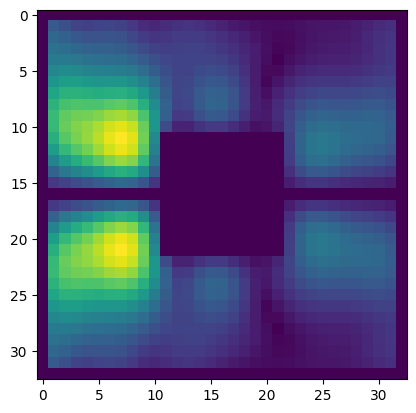

In [19]:
plt.imshow(np.abs(Ey_zx))

In [78]:
# calculate total field
data = od.data
Nx = od.Nx
Ny = od.Ny
Nz = od.Nz
c_fields = data["cfield"]
frequency = data["Freq2"][0]
"""
theta = data["Planewave"][0] 
phi = data["Planewave"][1] 
ei = np.array([data["Planewave"][2], data["Planewave"][3], data["Planewave"][4]])
hi = np.array([data["Planewave"][5], data["Planewave"][6], data["Planewave"][7]])
ri = np.array([data["Planewave"][8], data["Planewave"][9], data["Planewave"][10]])
r0 = np.array([data["Planewave"][11], data["Planewave"][12], data["Planewave"][13]])NA(od, ix, iy, iz)
ai = data["Planewave"][14]
pol = data["Planewave"][15]
"""
pw = Planewave_t(data["Planewave"])

Ex_zx = np.zeros((Nx, Nz), dtype=np.complex128)
Ey_zx = np.zeros((Nx, Nz), dtype=np.complex128)
Ez_zx = np.zeros((Nx, Nz), dtype=np.complex128)
Ex_zy = np.zeros((Ny, Nz), dtype=np.complex128)
Ey_zy = np.zeros((Ny, Nz), dtype=np.complex128)
Ez_zy = np.zeros((Ny, Nz), dtype=np.complex128)
Ex_yx = np.zeros((Nx, Ny), dtype=np.complex128)
Ey_yx = np.zeros((Nx, Ny), dtype=np.complex128)
Ez_yx = np.zeros((Nx, Ny), dtype=np.complex128)
iy = 15
for iz in range(Nz):
    for ix in range(Nx):
        e, h = cal_planewave(od, ix, iy, iz)

        Ex_zx[ix, iz] = complex(c_fields[0]["Ex_r"][NA(od, ix, iy, iz)], 
                                c_fields[0]["Ex_i"][NA(od, ix, iy, iz)]) + e[0]
        Ey_zx[ix, iz] = complex(c_fields[0]["Ey_r"][NA(od, ix, iy, iz)], 
                                c_fields[0]["Ey_i"][NA(od, ix, iy, iz)]) + e[1]
        Ez_zx[ix, iz] = complex(c_fields[0]["Ez_r"][NA(od, ix, iy, iz)], 
                                c_fields[0]["Ez_i"][NA(od, ix, iy, iz)]) + e[2]

ix = 15
for iz in range(Nz):
    for iy in range(Ny):
        e, h = cal_planewave(od, ix, iy, iz)
        Ex_zy[iy, iz] = complex(c_fields[0]["Ex_r"][NA(od, ix, iy, iz)],
                                c_fields[0]["Ex_i"][NA(od, ix, iy, iz)]) + e[0]
        Ey_zy[iy, iz] = complex(c_fields[0]["Ey_r"][NA(od, ix, iy, iz)],
                                c_fields[0]["Ey_i"][NA(od, ix, iy, iz)]) + e[1]
        Ez_zy[iy, iz] = complex(c_fields[0]["Ez_r"][NA(od, ix, iy, iz)],
                                c_fields[0]["Ez_i"][NA(od, ix, iy, iz)]) + e[2]

iz = 15
for ix in range(Nx):
    for iy in range(Ny):
        e, h = cal_planewave(od, ix, iy, iz)
        Ex_yx[ix, iy] = complex(c_fields[0]["Ex_r"][NA(od, ix, iy, iz)],
                                c_fields[0]["Ex_i"][NA(od, ix, iy, iz)]) + e[0]
        Ey_yx[ix, iy] = complex(c_fields[0]["Ey_r"][NA(od, ix, iy, iz)],
                                c_fields[0]["Ey_i"][NA(od, ix, iy, iz)]) + e[1]
        Ez_yx[ix, iy] = complex(c_fields[0]["Ez_r"][NA(od, ix, iy, iz)],
                                c_fields[0]["Ez_i"][NA(od, ix, iy, iz)]) + e[2]


In [79]:
def calculate_poynting_intensity(E_vec, H_vec):
    """
    Calculates the magnitude of the time-averaged Poynting vector.
    Formula: P_av = 1/2 * Re(E x H*)
    """
    
    # Calculate H* (complex conjugate of H)
    H_conj = np.conj(H_vec)
    
    # Calculate the cross product: E x H*
    # This results in a vector with complex components
    cross_product = np.cross(E_vec, H_conj)
    
    # Calculate the time-averaged Poynting vector (P_av)
    # Take the real part and multiply by 1/2
    P_av_vec = 0.5 * np.real(cross_product)
    
    # Calculate the magnitude (intensity) of P_av
    # This is the Euclidean norm: sqrt(Px^2 + Py^2 + Pz^2)
    intensity = np.linalg.norm(P_av_vec)
    
    return P_av_vec, intensity

In [80]:
def calculate_electric_field_intensity(Ex, Ey, Ez):
    """
    Calculates the magnitude of a complex electric field vector.
    Formula: |E| = sqrt(|Ex|^2 + |Ey|^2 + |Ez|^2)
    """
    
    # Calculate the squared magnitude of each complex component
    # np.abs(x)**2 is equivalent to x * np.conj(x)
    mag_sq = np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2
    
    # Take the square root to get the field intensity
    intensity = np.sqrt(mag_sq)
    
    return intensity

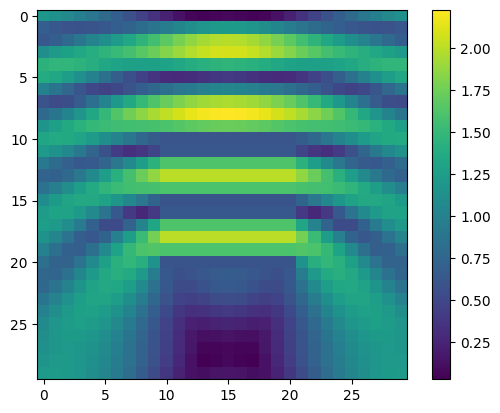

In [83]:
# 1. Define complex electric field component arrays (Ex, Ey, Ez)
# Example: 1D arrays representing points in space or time
#ex = np.array([1.0 + 1.0j, 0.0 + 2.0j, 3.0 - 1.0j])
#ey = np.array([0.5 - 0.5j, 1.0 + 0.0j, 0.0 + 2.0j])
#ez = np.array([0.0 + 0.0j, 0.0 + 1.0j, 1.0 + 1.0j])

# Execute the calculation
e_intensity = calculate_electric_field_intensity(Ex_yx, Ey_yx, Ez_yx)

# Output results
#print("--- Complex Field Components ---")
#print(f"Ex: {3ex}")
#print(f"Ey: {ey}")
#print(f"Ez: {ez}")
#print("\n--- Calculated Intensity ---")
#print(f"Field Magnitude |E|: {e_intensity}")

plt.imshow(e_intensity)
plt.colorbar()

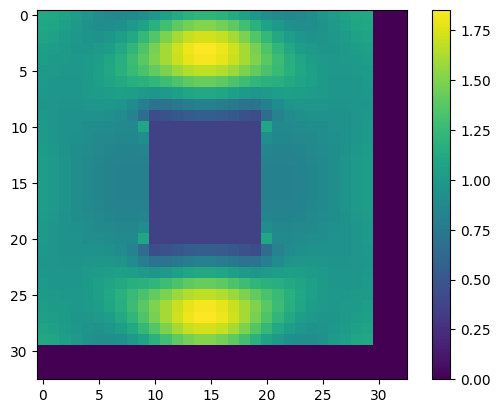

In [73]:
plt.imshow(np.abs(Ez_zy)**2)
plt.colorbar()

In [23]:
# 1. Define complex electric field (E) and magnetic field (H) vectors
# Example values (using 'j' for the imaginary unit)
E = np.array([1.0 + 2.0j, 0.5 - 1.0j, 0.0 + 0.0j])  # (Ex, Ey, Ez)
H = np.array([0.2 + 0.1j, 1.0 + 0.5j, 0.1 - 0.2j])  # (Hx, Hy, Hz)

# Execute calculation
p_vector, p_intensity = calculate_poynting_intensity(E, H)

# Output results
print("--- Results ---")
print(f"Time-averaged Poynting Vector (Px, Py, Pz): {p_vector}")
print(f"Intensity (Magnitude): {p_intensity:.4f} W/m^2")

NameError: name 'calculate_poynting_intensity' is not defined

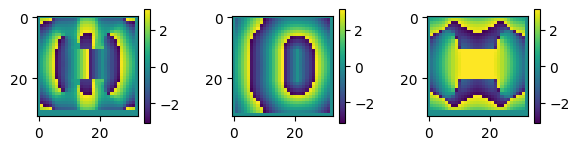

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))
im1 = axes[0].imshow(np.abs(Ex_zx))
fig.colorbar(im1, ax=axes[0], shrink=0.2)
im2 = axes[1].imshow(np.angle(Ex_zy))
fig.colorbar(im2, ax=axes[1], shrink=0.2)
im3 = axes[2].imshow(np.angle(Ex_yx))
fig.colorbar(im3, ax=axes[2], shrink=0.2)
plt.tight_layout()
plt.show()

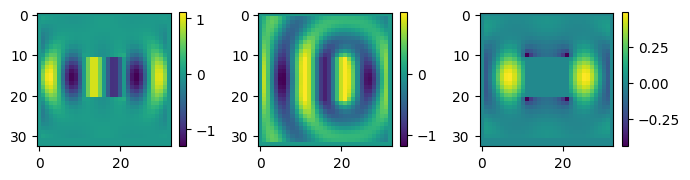

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 7))
im1 = axes[0].imshow(np.imag(Ex_zx))
fig.colorbar(im1, ax=axes[0], shrink=0.2)
im2 = axes[1].imshow(np.real(Ex_zy))
fig.colorbar(im2, ax=axes[1], shrink=0.2)
im3 = axes[2].imshow(np.imag(Ex_yx))
fig.colorbar(im3, ax=axes[2], shrink=0.2)
plt.tight_layout()
plt.show()

In [55]:
np.angle(1+1j)

np.float64(0.7853981633974483)

In [47]:
a = complex(1,1)
b = complex(3,4)


In [48]:
a+b

(4+5j)

In [6]:
np.sin(30*np.pi/180)


np.float64(0.49999999999999994)

In [7]:
30*np.pi/180

0.5235987755982988

odf.outから読んだデータをクラスReadOutData(OD)の変数にする
クラスReadOutDataを引数として、各関数にodf.outから読んだ変数を引き渡す。

ofd.outから読んだ変数を必要とする関数
場の位置インデックスの計算
def NA(OD, i, j, k):
    return k*OD.Nk + j*OD.Nj + i*OD.Ni +OD.N0

Planewaveの計算
def PlaneWave(OD, i, j, k):
    
